In [1]:
import sys
import datetime as dt
from copy import deepcopy
from os import getcwd
from os.path import dirname, join

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.linalg as la

PROJ_DIR = dirname(getcwd())
sys.path.append(PROJ_DIR)

SRC_DIR = join(PROJ_DIR, 'MAMMAL')
DATA_DIR = join(PROJ_DIR, 'data')
TEST_DIR = join(DATA_DIR, 'test')

from MAMMAL.Utils import ProcessingUtils as pu
from MAMMAL.Utils import Filters


%matplotlib inline
plt.rcParams["figure.figsize"] = (30, 30) # (w, h)
pd.set_option('mode.chained_assignment', None)


SURVEY_DIR = r'C:\Users\ltber\Desktop\files\AFIT\Research\WPAFB_Survey\data\flight_data\sensor_health_test'

LOG_1_CSV_FNAME      = 'sensor_health_v1_converted_log.csv'
LOG_2_CSV_FNAME      = 'sensor_health_v2_converted_log.csv'
LOG_1_MIAT_CSV_FNAME = 'sensor_health_MIAT_v1_converted_log.csv'
LOG_2_MIAT_CSV_FNAME = 'sensor_health_MIAT_v2_converted_log.csv'
LOG_1_NAME           = 'MFAM Sensor Health Test 1'
LOG_2_NAME           = 'MFAM Sensor Health Test 2'


def plot(timestamps,
         b_scalar_1,
         b_scalar_2,
         mfam_vec_dcs,
         vmr_dcs):
    _, (ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(8, 1, sharex=True)

    ax0.scatter(timestamps, b_scalar_1, s=1)
    ax0.set_title('Sensor Head 1 Measurements')
    ax0.set_ylabel('nT')
    ax0.set_xlabel('Timestamp')
    ax0.grid()

    ax1.scatter(timestamps, b_scalar_2, s=1)
    ax1.set_title('Sensor Head 2 Measurements')
    ax1.set_ylabel('nT')
    ax1.set_xlabel('Timestamp')
    ax1.grid()

    ax2.scatter(timestamps, mfam_vec_dcs[:, 0], s=1)
    ax2.set_title('MFAM Direction Cosines X-Component)')
    ax2.set_xlabel('Timestamp')
    ax2.grid()

    ax3.scatter(timestamps, mfam_vec_dcs[:, 1], s=1)
    ax3.set_title('MFAM Direction Cosines Y-Component)')
    ax3.set_xlabel('Timestamp')
    ax3.grid()

    ax4.scatter(timestamps, mfam_vec_dcs[:, 2], s=1)
    ax4.set_title('MFAM Direction Cosines Z-Component)')
    ax4.set_xlabel('Timestamp')
    ax4.grid()

    ax5.scatter(timestamps, vmr_dcs[:, 0], s=1)
    ax5.set_title('VMR Direction Cosines X-Component')
    ax5.set_xlabel('Timestamp')
    ax5.grid()

    ax6.scatter(timestamps, vmr_dcs[:, 1], s=1)
    ax6.set_title('VMR Direction Cosines Y-Component')
    ax6.set_xlabel('Timestamp')
    ax6.grid()

    ax7.scatter(timestamps, vmr_dcs[:, 2], s=1)
    ax7.set_title('VMR Direction Cosines Z-Component')
    ax7.set_xlabel('Timestamp')
    ax7.grid()

In [2]:
log_df     = pd.read_csv(join(SURVEY_DIR, LOG_1_CSV_FNAME), parse_dates=['datetime'])
datetimes  = log_df.datetime
timestamps = np.array(log_df.epoch_sec)

In [3]:
# Credit: https://stackoverflow.com/a/71230493/9860973

CLIP_X_HIGH  = 60620
CLIP_X_LOW   = -51835
X_SPAN       = 20
X_DELTA      = 10

log_df['x_clipped']         = pu.clip_data(log_df.X_MFAM.tolist(), CLIP_X_HIGH, CLIP_X_LOW)
log_df['x_ewma_fb']         = pu.ewma_fb(log_df['x_clipped'], X_SPAN)
log_df['x_remove_outliers'] = pu.remove_outliers(log_df['x_clipped'].tolist(), log_df['x_ewma_fb'].tolist(), X_DELTA)
log_df['x_interpolated']    = log_df['x_remove_outliers'].interpolate()

CLIP_Y_HIGH  = 13100
CLIP_Y_LOW   = -29557
Y_SPAN       = 20
Y_DELTA      = 10

log_df['y_clipped']         = pu.clip_data(log_df.Y_MFAM.tolist(), CLIP_Y_HIGH, CLIP_Y_LOW)
log_df['y_ewma_fb']         = pu.ewma_fb(log_df['y_clipped'], Y_SPAN)
log_df['y_remove_outliers'] = pu.remove_outliers(log_df['y_clipped'].tolist(), log_df['y_ewma_fb'].tolist(), Y_DELTA)
log_df['y_interpolated']    = log_df['y_remove_outliers'].interpolate()

CLIP_Z_HIGH  = 56277
CLIP_Z_LOW   = -49948
Z_SPAN       = 20
Z_DELTA      = 10

log_df['z_clipped']         = pu.clip_data(log_df.Z_MFAM.tolist(), CLIP_Z_HIGH, CLIP_Z_LOW)
log_df['z_ewma_fb']         = pu.ewma_fb(log_df['z_clipped'], Z_SPAN)
log_df['z_remove_outliers'] = pu.remove_outliers(log_df['z_clipped'].tolist(), log_df['z_ewma_fb'].tolist(), Z_DELTA)
log_df['z_interpolated']    = log_df['z_remove_outliers'].interpolate()

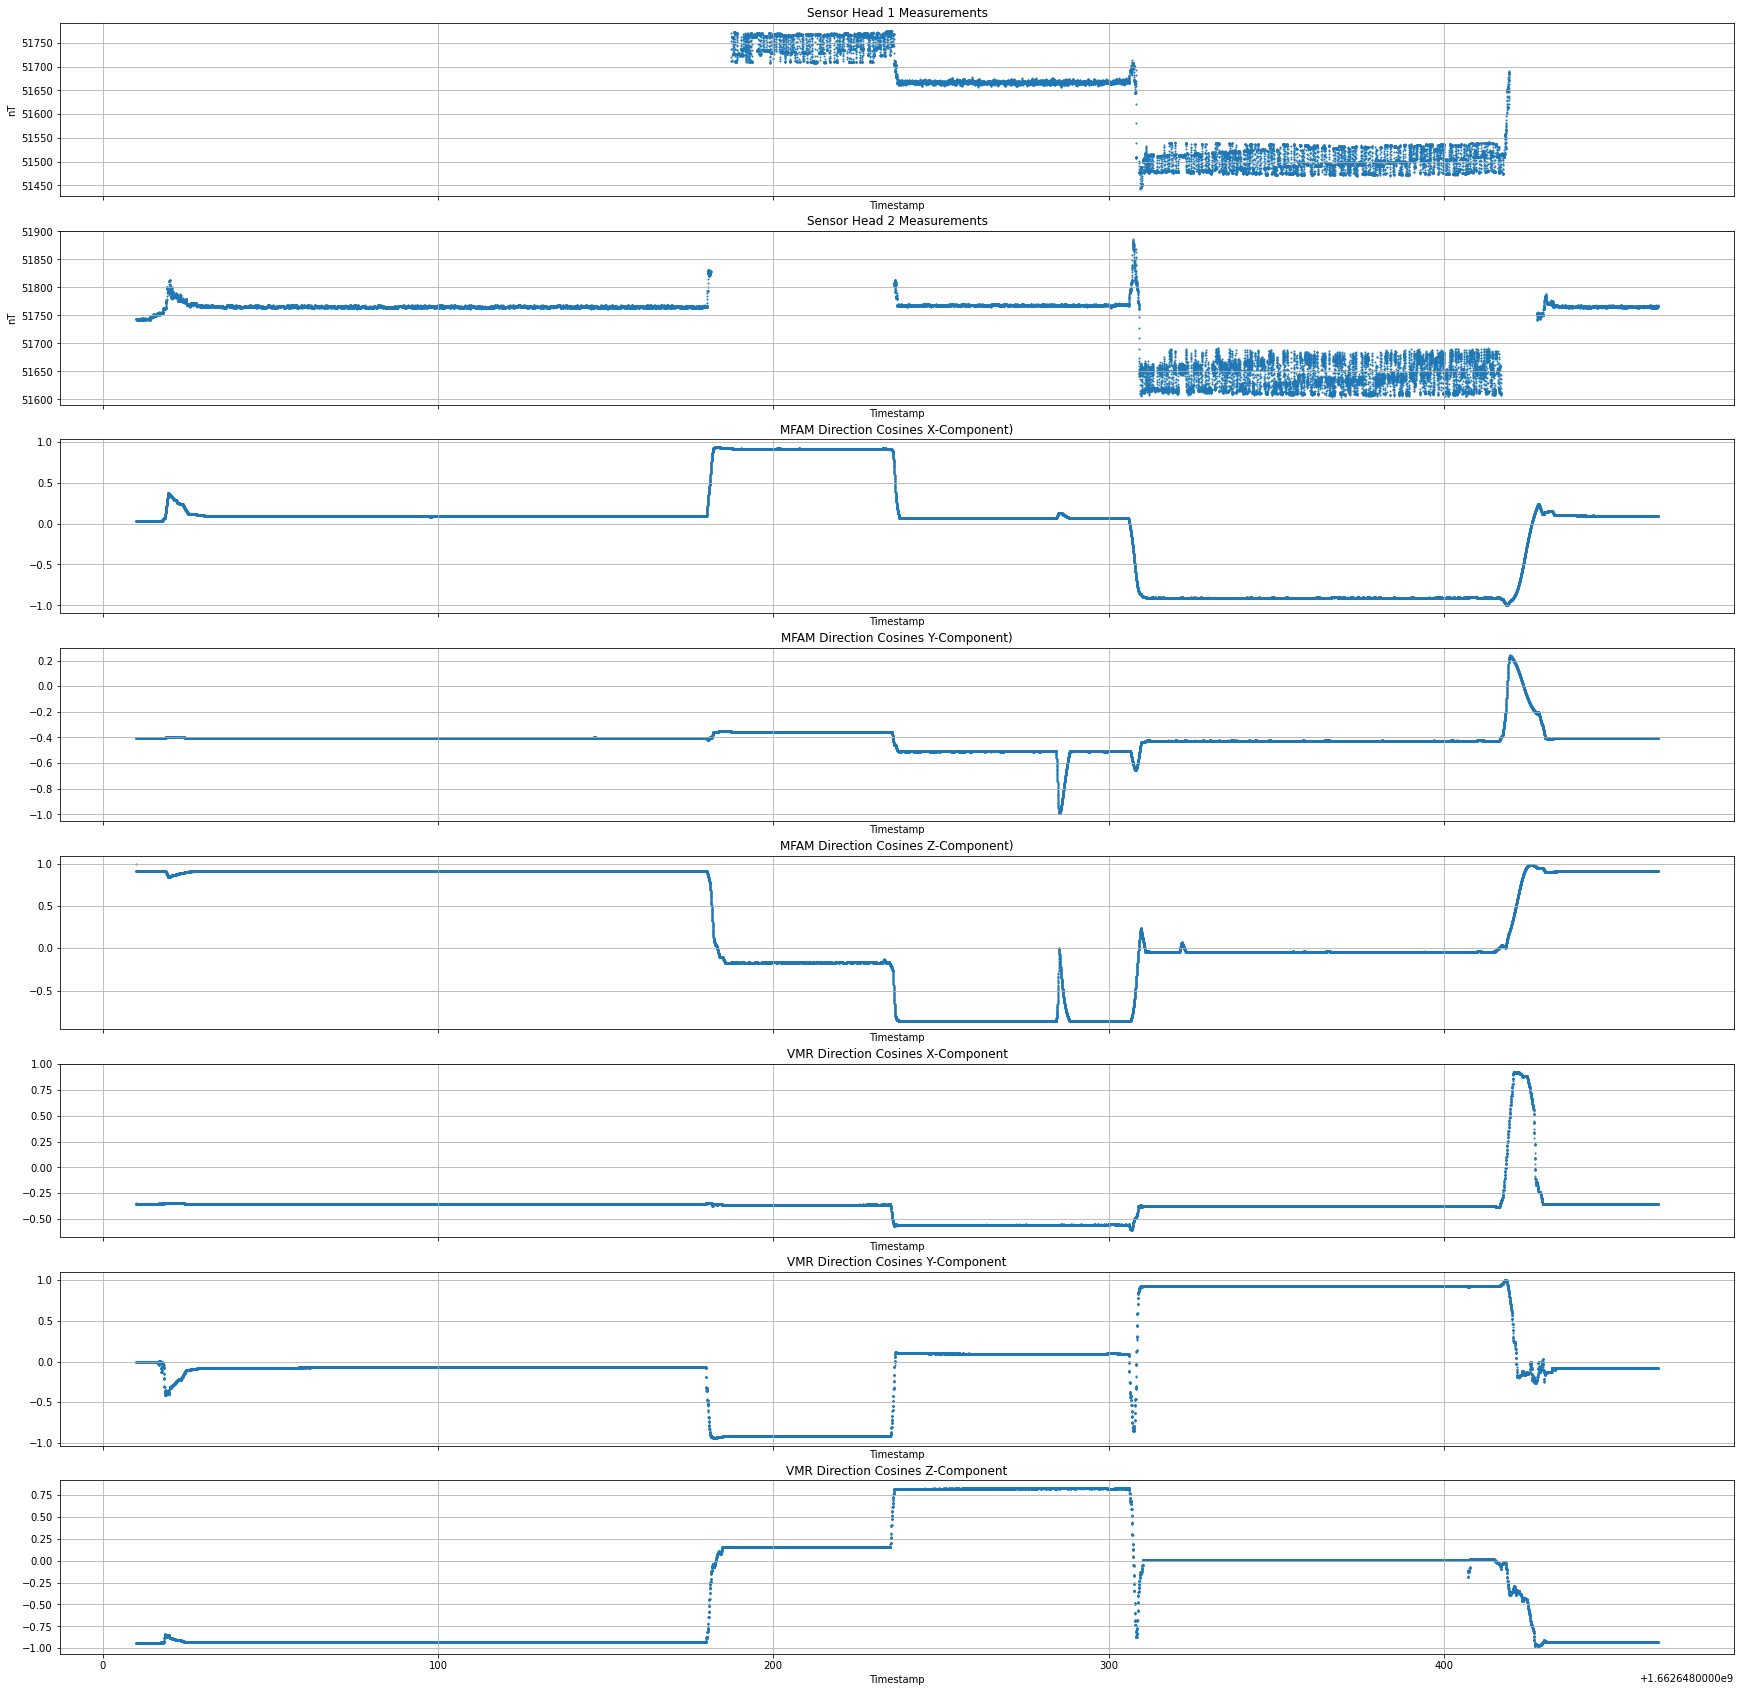

In [4]:
b_scalar_1 = log_df.SCALAR_1
b_scalar_1[~log_df.SCALAR_1_VALID] = np.nan

b_scalar_2 = log_df.SCALAR_2
b_scalar_2[~log_df.SCALAR_2_VALID] = np.nan

vmr = np.hstack([np.array(log_df.X)[:, np.newaxis], 
                 np.array(log_df.Y)[:, np.newaxis],
                 np.array(log_df.Z)[:, np.newaxis]])
vmr_magnitude = la.norm(vmr, axis=1)
vmr_dcs = vmr / vmr_magnitude[:, np.newaxis]

mfam_vec = np.hstack([np.array(log_df.x_interpolated)[:, np.newaxis], 
                      np.array(log_df.y_interpolated)[:, np.newaxis],
                      np.array(log_df.z_interpolated)[:, np.newaxis]])
mfam_vec_magnitude = la.norm(np.nan_to_num(mfam_vec), axis=1)
mfam_vec_dcs = mfam_vec / mfam_vec_magnitude[:, np.newaxis]

plot(timestamps   = timestamps,
     b_scalar_1   = b_scalar_1,
     b_scalar_2   = b_scalar_2,
     mfam_vec_dcs = mfam_vec_dcs,
     vmr_dcs      = vmr_dcs)

In [7]:
log_df     = pd.read_csv(join(SURVEY_DIR, LOG_2_CSV_FNAME), parse_dates=['datetime'])
datetimes  = log_df.datetime
timestamps = np.array(log_df.epoch_sec)

In [8]:
# Credit: https://stackoverflow.com/a/71230493/9860973

CLIP_X_HIGH  = 60129
CLIP_X_LOW   = -47550
X_SPAN       = 20
X_DELTA      = 10

log_df['x_clipped']         = pu.clip_data(log_df.X_MFAM.tolist(), CLIP_X_HIGH, CLIP_X_LOW)
log_df['x_ewma_fb']         = pu.ewma_fb(log_df['x_clipped'], X_SPAN)
log_df['x_remove_outliers'] = pu.remove_outliers(log_df['x_clipped'].tolist(), log_df['x_ewma_fb'].tolist(), X_DELTA)
log_df['x_interpolated']    = log_df['x_remove_outliers'].interpolate()

CLIP_Y_HIGH  = -21781
CLIP_Y_LOW   = -23978
Y_SPAN       = 20
Y_DELTA      = 10

log_df['y_clipped']         = pu.clip_data(log_df.Y_MFAM.tolist(), CLIP_Y_HIGH, CLIP_Y_LOW)
log_df['y_ewma_fb']         = pu.ewma_fb(log_df['y_clipped'], Y_SPAN)
log_df['y_remove_outliers'] = pu.remove_outliers(log_df['y_clipped'].tolist(), log_df['y_ewma_fb'].tolist(), Y_DELTA)
log_df['y_interpolated']    = log_df['y_remove_outliers'].interpolate()

CLIP_Z_HIGH  = 53446
CLIP_Z_LOW   = -10220
Z_SPAN       = 20
Z_DELTA      = 10

log_df['z_clipped']         = pu.clip_data(log_df.Z_MFAM.tolist(), CLIP_Z_HIGH, CLIP_Z_LOW)
log_df['z_ewma_fb']         = pu.ewma_fb(log_df['z_clipped'], Z_SPAN)
log_df['z_remove_outliers'] = pu.remove_outliers(log_df['z_clipped'].tolist(), log_df['z_ewma_fb'].tolist(), Z_DELTA)
log_df['z_interpolated']    = log_df['z_remove_outliers'].interpolate()

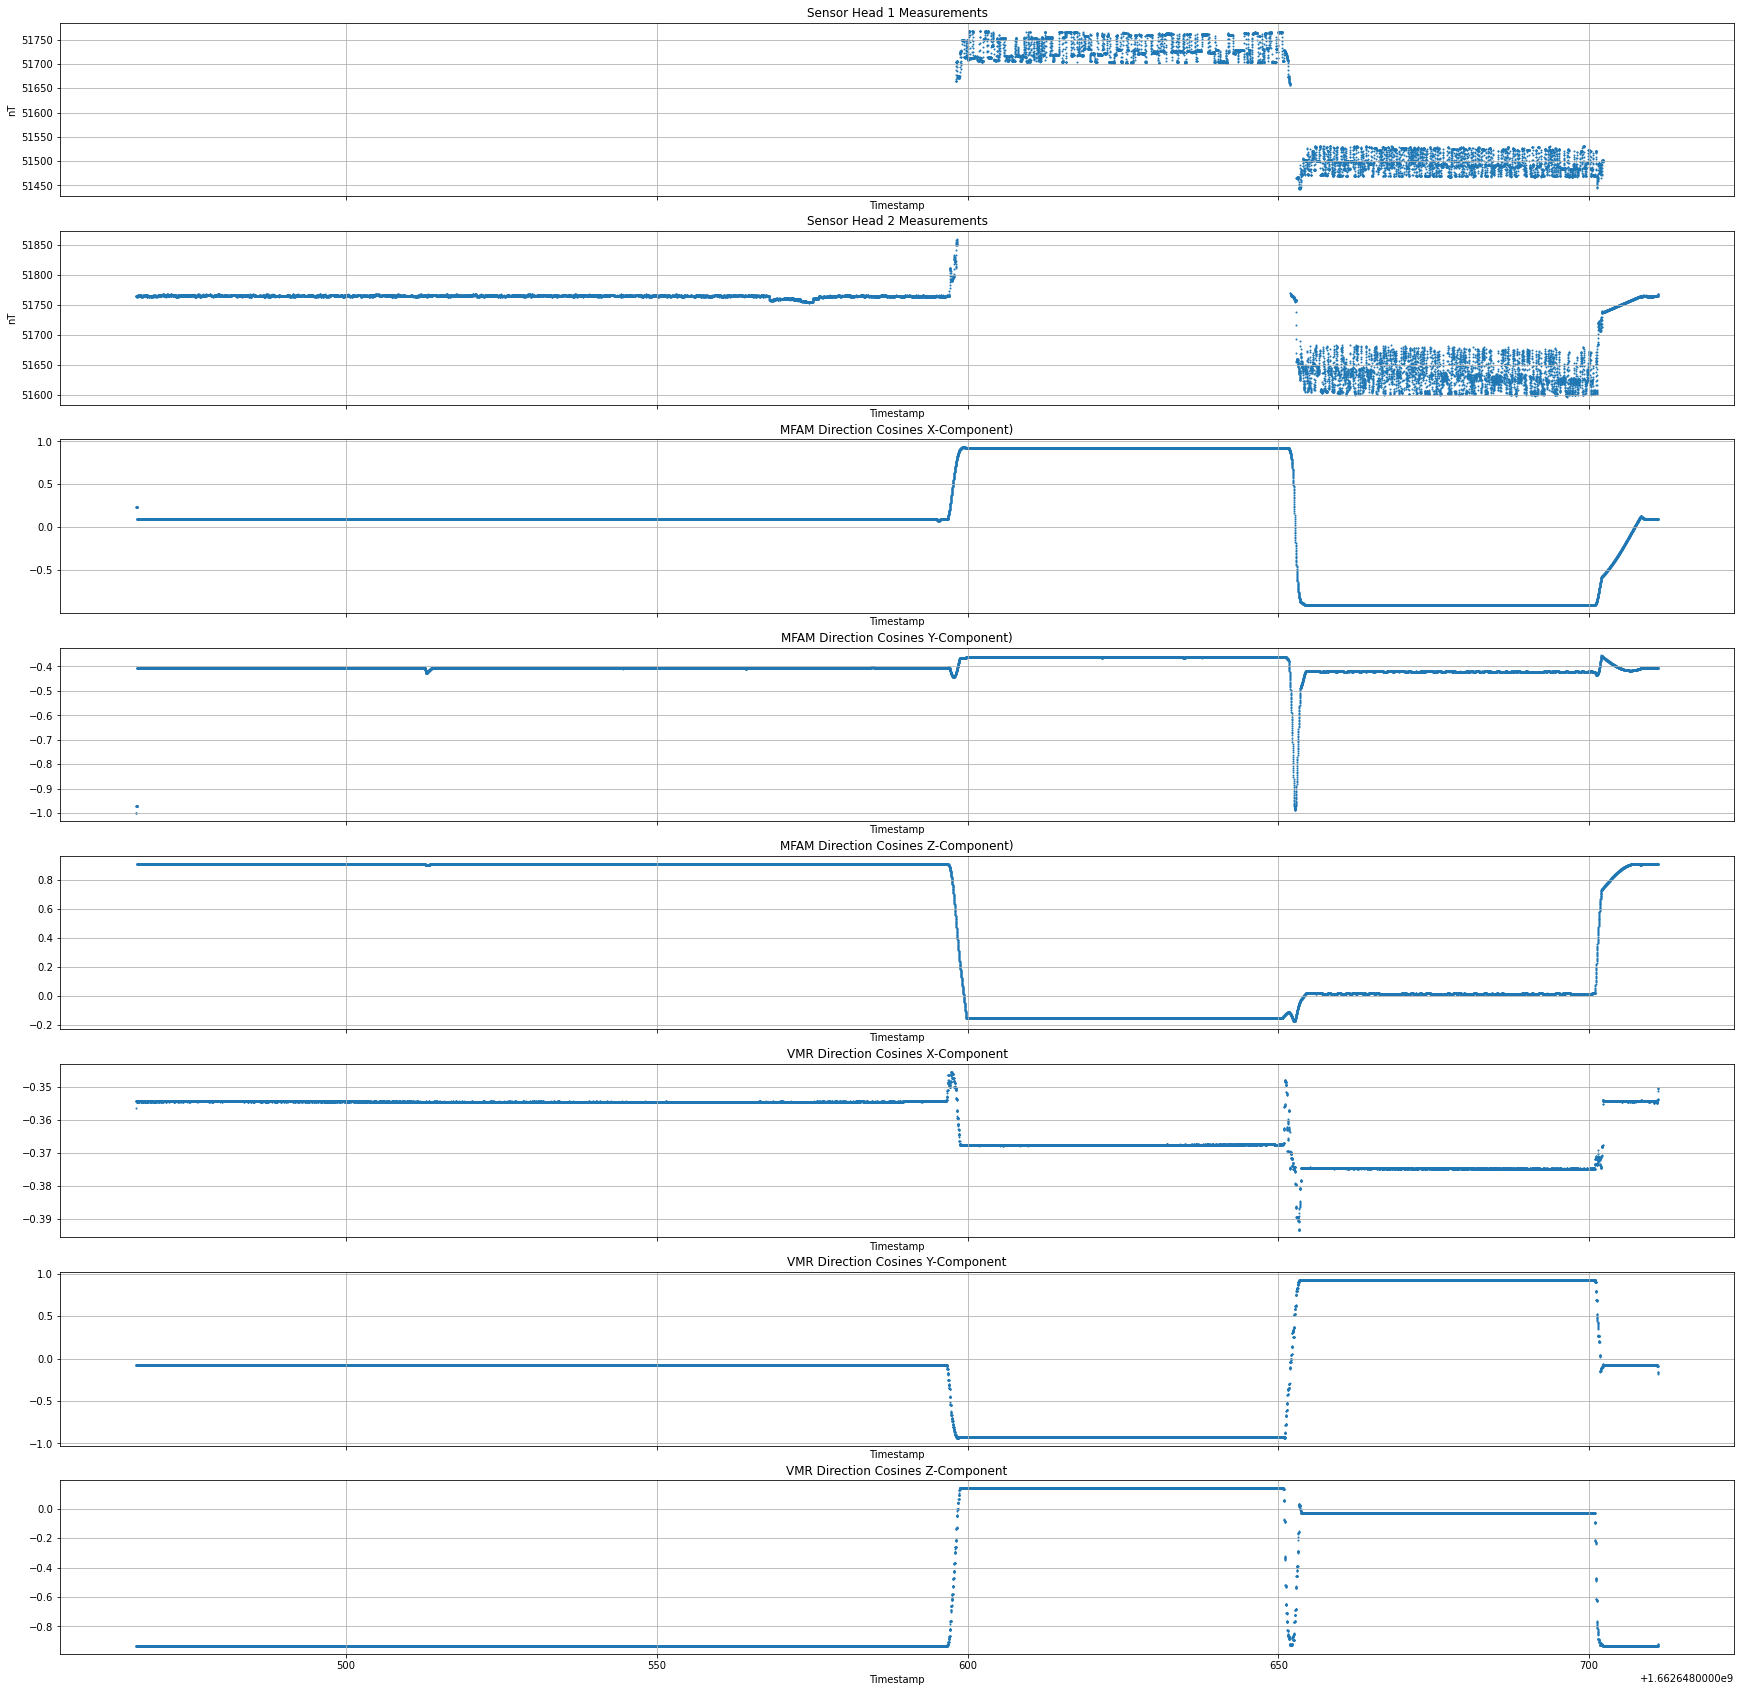

In [9]:
b_scalar_1 = log_df.SCALAR_1
b_scalar_1[~log_df.SCALAR_1_VALID] = np.nan

b_scalar_2 = log_df.SCALAR_2
b_scalar_2[~log_df.SCALAR_2_VALID] = np.nan

vmr = np.hstack([np.array(log_df.X)[:, np.newaxis], 
                 np.array(log_df.Y)[:, np.newaxis],
                 np.array(log_df.Z)[:, np.newaxis]])
vmr_magnitude = la.norm(vmr, axis=1)
vmr_dcs = vmr / vmr_magnitude[:, np.newaxis]

mfam_vec = np.hstack([np.array(log_df.x_interpolated)[:, np.newaxis], 
                      np.array(log_df.y_interpolated)[:, np.newaxis],
                      np.array(log_df.z_interpolated)[:, np.newaxis]])
mfam_vec_magnitude = la.norm(np.nan_to_num(mfam_vec), axis=1)
mfam_vec_dcs = mfam_vec / mfam_vec_magnitude[:, np.newaxis]

plot(timestamps   = timestamps,
     b_scalar_1   = b_scalar_1,
     b_scalar_2   = b_scalar_2,
     mfam_vec_dcs = mfam_vec_dcs,
     vmr_dcs      = vmr_dcs)